# Generating Features for Heavy Drinking Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Splitting Dataset into Timed Windows

In [2]:
def create_data_windows(pid, window):
    df = pd.read_parquet(f"{pid}_balanced_250hz.parquet")
    grouped = df.groupby(pd.Grouper(key='time', freq=window))

    return grouped

In [3]:
grouped = create_data_windows("BU4707", "4S")

## Feature Calculation Functions

In [4]:
# descriptive statistic features

def generate_mean(df_window):
    mean_features = []
    for field in ['x', 'y', 'z', 'magnitude']:
        mean_features.append(np.mean(df_window[field]))

    return mean_features


def generate_stdev(df_window):
    std_features = []
    for field in ['x', 'y', 'z', 'magnitude']:
        std_features.append(np.std(df_window[field]))

    return std_features


def generate_median(df_window):
    median_features = []
    for field in ['x', 'y', 'z', 'magnitude']:
        median_features.append(np.median(df_window[field]))

    return median_features


def generate_zero_crossing_rate(df_window):
    zero_crossing_rate_features = []
    for field in ['x', 'y', 'z']:
        changes = np.sign(df_window[field]).diff()
        num_crossings = (changes != 0).sum()
        percent_crossings = num_crossings / len(df_window)
        zero_crossing_rate_features.append(percent_crossings)

    return zero_crossing_rate_features


def generate_max(df_window):
    max_features = []
    for field in ['x', 'y', 'z', 'magnitude']:
        max_features.append(np.max(abs(df_window[field])))

    return max_features


def generate_time_domain_entropy(df_window, num_bins=10):
    # Discretize the signal into bins
    bins = np.linspace(min(df_window['XYZ_sum']), max(df_window['XYZ_sum']), num_bins+1)
    
    # Count occurrences of values falling into each bin
    counts, _ = np.histogram(df_window['XYZ_sum'], bins=bins)
    
    # Calculate probability distribution
    probabilities = counts / len(df_window['XYZ_sum'])
    
    # Calculate entropy using Shannon entropy formula
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add small epsilon to avoid log(0)
    
    return [entropy]

In [19]:
# features requiring fast fourier transform

def generate_frequency_domain_entropy(df_window, num_bins=10):
    # Apply the FFT to the signal
    fft_result = np.fft.fft(df_window['XYZ_sum'])
    
    # Calculate the power spectrum
    power_spectrum = np.abs(fft_result) ** 2
    
    # Discretize the power spectrum into bins
    bins = np.linspace(min(power_spectrum), max(power_spectrum), num_bins+1)
    
    # Count occurrences of values falling into each bin
    counts, _ = np.histogram(power_spectrum, bins=bins)
    
    # Calculate probability distribution
    probabilities = counts / len(power_spectrum)
    
    # Calculate entropy using Shannon entropy formula
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Add small epsilon to avoid log(0)
    
    return [entropy]


def generate_spectral_centroid_and_spread(df_window):
    # Calculating the weighted mean and variance of frequencies
    # The index in the fft_result is the frequency, and the real component of the fft represents the amplitude of the FFT

    # Apply the FFT to the signal
    fft_result = np.fft.fft(df_window['XYZ_sum'])

    frequencies = np.array(range(len(fft_result)))
    amplitudes = np.array([fft_result[i].real for i in range(len(fft_result))])

    centroid = np.dot(frequencies, amplitudes)

    sqd_dev = 0
    for i in range(len(frequencies)):
        sqd_dev += (i - centroid)**2 * amplitudes[i]
    spread = sqd_dev / np.sum(amplitudes)

    return [centroid, spread]


def generate_spectral_flux_and_rolloff(df_window):
    # Returns the flux, which is a measure of the speed of change between two consecutive FFTs
    # and the roll-off, which is the frequency below which 90% of the energy is contained

    fft_result = np.fft.fft(df_window['XYZ_sum'])
    magnitude_spectrum = np.abs(fft_result)

    # Calculating Flux
    squared_diff = np.diff(magnitude_spectrum, axis=0) ** 2
    spectral_flux = np.sum(squared_diff)

    # Calculating Rolloff
    cum_sum = np.cumsum(magnitude_spectrum)
    # Normalize cumulative sum by total sum
    cum_sum /= np.sum(magnitude_spectrum)
    roll_off = np.argmax(cum_sum >= 0.9)

    return [spectral_flux, roll_off]



## Calculating Features

In [20]:
def generate_features(grouped):
    feature_df_rows = []
    col_names = ['time', 'pid', 'x_mean', 'y_mean', 'z_mean', 'mag_mean', 'x_std', 'y_std', 'z_std', 'mag_std', 
                'x_median', 'y_median', 'z_median', 'mag_median', 'x_crossing', 'y_crossing', 'z_crossing', 
                'x_max', 'y_max', 'z_max', 'mag_max', 'time_entropy', 'frequency_entropy', 'spectral_centroid',
                'spectral_spread', 'spectral_flux', 'spectral_rolloff', 'TAC_class']

    # the group name is the start of the window
    for group_name, group_data in tqdm(grouped):
        # the last TAC class value in the window will be the label of the feature
        TAC_class_label = group_data['TAC_class'].iloc[-1]
        
        # converting a list of data to a dataframe
        feature_funcs = [generate_mean, generate_stdev, generate_median, generate_zero_crossing_rate, generate_max, generate_time_domain_entropy,
                        generate_frequency_domain_entropy, generate_spectral_centroid_and_spread, generate_spectral_flux_and_rolloff]
        data = [group_name, group_data['pid'].iloc[0]]
        for func in feature_funcs:
            data += func(group_data)
        data += [TAC_class_label]
        
        feature_row = pd.DataFrame([data], columns=col_names)
        feature_df_rows.append(feature_row)

    feature_df = pd.concat(feature_df_rows)

    return feature_df

In [24]:
pids = ['SA0297','PC6771','BK7610','DC6359','MC7070','MJ8002','BU4707','JR8022','HV0618','SF3079','JB3156','CC6740','DK3500']

In [29]:
pid_features = []
for pid in pids:
    print(f"pid: {pid}")
    grouped = create_data_windows(pid, "4S")
    features_df = generate_features(grouped)

    pid_features.append(features_df)

pid: SA0297


100%|██████████| 11630/11630 [01:15<00:00, 154.60it/s]


pid: PC6771


100%|██████████| 6197/6197 [00:38<00:00, 159.12it/s]


pid: BK7610


 26%|██▌       | 2085/7976 [00:11<00:28, 206.97it/s]/var/folders/kk/v1dq6w817kb25skcwjv3tgyw0000gn/T/ipykernel_1474/2842738104.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  spread = sqd_dev / np.sum(amplitudes)
100%|██████████| 7976/7976 [00:41<00:00, 193.43it/s]


pid: DC6359


100%|██████████| 8145/8145 [00:42<00:00, 191.66it/s]


pid: MC7070


100%|██████████| 10903/10903 [00:57<00:00, 188.51it/s]


pid: MJ8002


100%|██████████| 7912/7912 [00:43<00:00, 182.85it/s]


pid: BU4707


100%|██████████| 5105/5105 [00:26<00:00, 194.08it/s]


pid: JR8022


100%|██████████| 8522/8522 [00:47<00:00, 178.25it/s]


pid: HV0618


100%|██████████| 8550/8550 [00:48<00:00, 177.35it/s]


pid: SF3079


100%|██████████| 10301/10301 [00:57<00:00, 178.14it/s]


pid: JB3156


100%|██████████| 10167/10167 [00:59<00:00, 169.73it/s]


pid: CC6740


100%|██████████| 9955/9955 [00:55<00:00, 178.73it/s]


pid: DK3500


  9%|▉         | 478/5303 [00:02<00:30, 156.98it/s]/var/folders/kk/v1dq6w817kb25skcwjv3tgyw0000gn/T/ipykernel_1474/2842738104.py:40: RuntimeWarning: invalid value encountered in double_scalars
  spread = sqd_dev / np.sum(amplitudes)
/var/folders/kk/v1dq6w817kb25skcwjv3tgyw0000gn/T/ipykernel_1474/2842738104.py:59: RuntimeWarning: invalid value encountered in divide
  cum_sum /= np.sum(magnitude_spectrum)
100%|██████████| 5303/5303 [00:32<00:00, 162.90it/s]


In [51]:
features_df = pd.concat(pid_features, axis=0)

# dropping nan and inf values
features_df = features_df.replace([np.inf, -np.inf], np.nan).dropna()

In [54]:
# features_df.to_parquet("balanced_features.parquet")

In [55]:
features_df = pd.read_parquet("balanced_features.parquet")

features_df

,time,pid,x_mean,y_mean,z_mean,mag_mean,x_std,y_std,z_std,mag_std,...,y_max,z_max,mag_max,time_entropy,frequency_entropy,spectral_centroid,spectral_spread,spectral_flux,spectral_rolloff,TAC_class
0,2017-05-02 14:04:40,SA0297,-0.222442,-0.075598,-0.015889,0.242998,6.988053e-02,3.550172e-02,7.062066e-03,5.092628e-02,...,0.0861,0.0849,0.293697,6.161106e-01,0.025375,3.205993e+04,9.724189e+08,1.265986e+04,392,0.0
0,2017-05-02 14:04:44,SA0297,0.009088,-0.042815,-0.008202,0.073136,3.185934e-02,5.166347e-02,2.756228e-02,3.283147e-02,...,0.1881,0.1161,0.227391,2.089842e+00,0.049024,-1.743570e+04,3.120597e+08,1.920136e+03,987,0.0
0,2017-05-02 14:04:48,SA0297,0.000233,0.000279,-0.012446,0.056119,2.208625e-02,1.088092e-02,5.806136e-02,3.135288e-02,...,0.0324,0.1393,0.146422,2.926396e+00,0.247524,8.175000e+02,5.876386e+05,1.740432e+03,990,0.0
0,2017-05-02 14:04:52,SA0297,0.015000,0.012800,-0.025800,0.032473,6.938894e-18,3.469447e-18,6.938894e-18,6.938894e-18,...,0.0128,0.0258,0.032473,-1.442695e-10,0.011408,3.105155e-13,1.286114e-10,4.000000e+00,0,0.0
0,2017-05-02 14:04:56,SA0297,0.028955,0.019178,-0.011516,0.118029,1.039950e-01,5.769088e-02,1.421302e-01,1.474860e-01,...,0.2176,0.7028,0.715980,1.300715e+00,0.308401,-1.730865e+04,-7.448975e+06,3.402120e+03,991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-05-02 22:58:24,DK3500,-0.282059,0.812773,0.919243,1.494816,5.524381e-01,7.710623e-01,4.508139e-01,6.735337e-01,...,3.6328,2.8105,4.068333,2.195081e+00,0.011408,1.963719e+05,3.852014e+10,2.606618e+06,973,0.0
0,2017-05-02 22:58:28,DK3500,-0.398836,0.841703,0.873992,1.500703,5.797443e-01,6.457703e-01,4.180652e-01,5.542438e-01,...,2.2785,2.4691,3.493737,2.831896e+00,0.011408,-1.217293e+05,1.479031e+10,1.813968e+06,985,0.0
0,2017-05-02 22:58:32,DK3500,-0.395525,0.851949,0.918978,1.517392,5.291713e-01,6.721786e-01,4.653721e-01,6.105056e-01,...,3.0226,2.8839,3.568501,2.319288e+00,0.011408,-9.660115e+04,9.315850e+09,2.201106e+06,975,0.0
0,2017-05-02 22:58:36,DK3500,-0.445867,0.862403,0.879934,1.460645,4.950609e-01,5.739813e-01,3.984550e-01,5.627110e-01,...,1.9277,2.4865,3.384682,2.608129e+00,0.011408,-6.160347e+05,3.677053e+11,1.677647e+06,981,0.0


## Feature Visualization

In [42]:
def plot_feature_vs_feature(df, pid, feature_x, feature_y):
    # Set seaborn style
    sns.set_style("whitegrid")

    pid_df = df.loc[df['pid'] == pid]
    size = min(10000, len(pid_df))
    pid_subset = pid_df.sample(size)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature_x, y=feature_y, hue='TAC_class', data=pid_subset, palette='viridis', s=10)
    plt.title(f'{feature_x} vs. {feature_y} Visualization')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title='TAC Class', loc='upper right')
    plt.show()

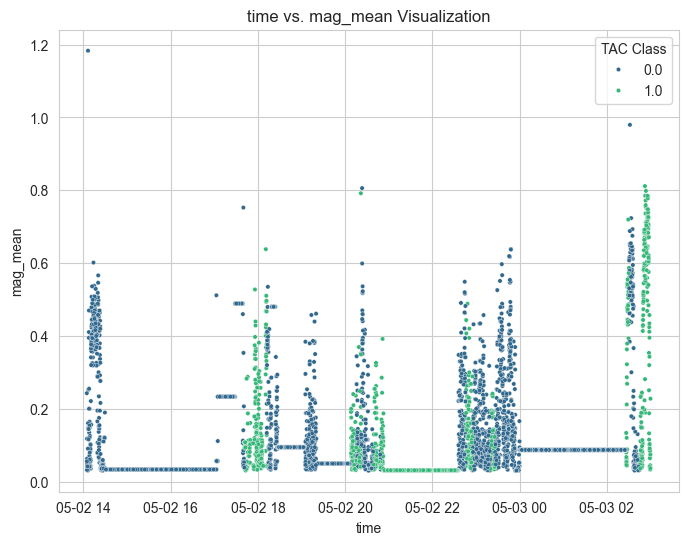

In [45]:
plot_feature_vs_feature(features_df, 'SA0297', 'time', 'mag_mean')